<a href="https://colab.research.google.com/github/Roarou/Computational-control/blob/main/COCO_Tutorial_MPC3_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Economic MPC vs Tracking MPC

# Stability with terminal state constraint
We have the following LTI dynamics

$$ x_{k+1} = A\, x_k + B \,u_k  = \left[\begin{smallmatrix} 0.857 & 0.884 \\ -0.0147& -0.0151 \end{smallmatrix}\right] x_k + \left[\begin{smallmatrix}  8.57\\ 0.884\end{smallmatrix}\right] u_k.$$

with $x_k \in \mathbb{R}^2$ and $u_k \in \mathbb{R}$. 
Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{minimize} & \sum_{k=0}^{K-1} \ell(x_k, u_k)\\
\mbox{subject to} & x_{k+1} = Ax_k + Bu_k\\%, \quad k=0, \ldots, K-1\\
& \| u_k\|_{\infty}\leq 1, \quad x_0 = \left[\begin{smallmatrix} 80 \\ 10 \end{smallmatrix}\right].
\end{array}

Where the tracking MPC has the following cost function:
\begin{equation}
\ell_{tr}(x_k, u_k) = \|x_k -x_s \|^2_Q + \| u_k -u_s\|_R^2
\end{equation}
with $Q = \left[\begin{smallmatrix} 2& 0 \\ 0 & 2 \end{smallmatrix}\right]$ and $R = 2$. 

The economic MPC has the following economic cost function:

\begin{equation}
\ell_{ec}(x_k, u_k) = q^T x_k + r\, u_K
\end{equation}
 
with $q =  \left[\begin{smallmatrix}  -3\\-2\end{smallmatrix}\right]$ and $r = -2$.

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt


n_x, n_u = 2,1

A = np.array([[0.857 ,0.884], [-0.0147, -0.0151]])
B = np.array([8.57, 0.884])
T = 30
K= 7

### Exercise 1:

Compute the steady state $x_s$ for a fixed steady-state input of $u_1 = 1$. 

In [ ]:
u_s = 1
x_s = (np.linalg.inv(np.eye(2)-A)@B * u_s).round(2)

print('x_s = ' + str(x_s))

x_s = [59.95  0.  ]


### Exercise 2:

Fill in the lines of code below for the tracking MPC and the economic MPC. Compare the two outputs and answer the questions.

In [ ]:
#%%

Q = 2*np.eye(n_x)
R = 2

x_0 = np.array([80,10])

x_traj = np.zeros([n_x, T+1]) 
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):
    
    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))
    
    cost = 0
    constr = []
    for k in range(K):
        cost +=  cp.quad_form(x[:, k] - x_s,Q) + R * (u[:, k]- u_s)**2 
        constr += [x[:, k + 1] == A @ x[:, k] + B * u[:, k], cp.norm(u[:, k], 'inf') <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False)     
    
    x_0 = A @ x_0 + B * u[:,0].value
    
    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0
  
u_tra = u_traj.copy()   
x_tra = x_traj.copy()  

In [ ]:
r = -2
q = np.array([-3,-2])

x_0 = np.array([80,10])

x_traj = np.zeros([n_x, T+1]) 
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):
    
    x = cp.Variable((n_x, K + 1))
    u = cp.Variable((n_u, K))
    
    cost = 0
    constr = []
    for k in range(K):
        cost +=  q @ x[:, k] + r * u[:, k]
        constr += [x[:, k + 1] == A @ x[:, k] + B * u[:, k], cp.norm(u[:, k], 'inf') <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False)     
    
    x_0 = A @ x_0 + B * u[:,0].value
    
    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0
  
u_eco = u_traj.copy()   
x_eco = x_traj.copy() 

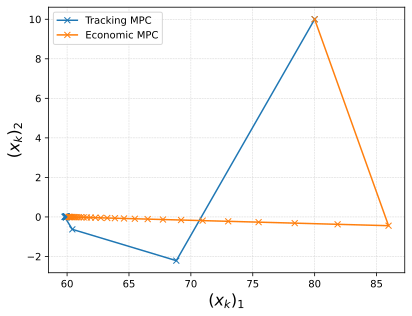

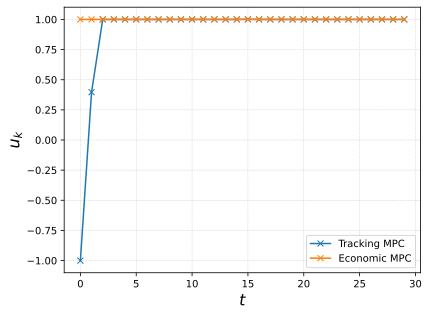

In [ ]:
%config InlineBackend.figure_format = 'svg'

f1 = plt.figure()

plt.plot(x_tra[0,:], x_tra[1,:], marker = 'x')
plt.plot(x_eco[0,:], x_eco[1,:], marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xlabel("$(x_k)_1$", fontsize=16) 
plt.ylabel("$(x_k)_2$", fontsize=16) 
plt.legend(['Tracking MPC', 'Economic MPC'])

f2 = plt.figure()

plt.plot(u_tra[0,:], marker = 'x')
plt.plot(u_eco[0,:], marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.ylabel("$u_k$", fontsize=16) 
plt.xlabel("$t$", fontsize=16) 
plt.legend(['Tracking MPC', 'Economic MPC'])

**Question 1:**

Why is the output of the economic MPC different to the tracking MPC?

**Answer 1:**

The tracking MPC cost only penalizes the distance to steady-state input and the steady state and thus tries to reach it quickly. Whereas the economic cost in the EMPC is trying to maximize input and state and therefore stay longer in the area with the higher state and the converges to the steady state following the stable dynamics always applying the maximal input $u_s=1$ as this is "economically" optimal.

**Question 2:**

Which of the two controller give the lower **economic** cost? 

**Answer 2:**

The EMPC controller as it not only converges to the economically optmial steady state but also optimizes the cost along the transient phase while the system is converging from the initial state to the steady state.

**Question 3:**

Why does the economic MPC converge to the optimal steady state of the system if there is no terminal state constraint to do so?

**Answer 3:**

The EMPC cost is trying to maximize input and states of the system which can be achieved by applying the maximal input $u=1$. Thus, the EMPC controller continuously applies the input of $u=1$ and then overtime (following the dynamics of the system) converges to the corresponding steady state $x_0 = \left[\begin{smallmatrix} 60 \\ 0 \end{smallmatrix}\right]$.

**Question 4:**

Can you modifiy the cost matrices of the tracking MPC problem such that the two outputs match? 

**Answer 4:**

Yes in this example, with a linear cost and only input constraints, the trajectories of the two systems conicide for $Q = \left[\begin{smallmatrix} 0& 0 \\ 0 & 0 \end{smallmatrix}\right]$. In this case the tracking MPC only penalizes the distance to the steady-state input and also applies a constant input $u = u_s =1$ which is the same as the input of the EMPC.

# Robust MPC

We want to implement the worst-case robust MPC example from the lecture from Slide 6. You can use the sceleton code below. It is enough to implement the constraints for the worst-case noise realizations, so $w_{max} = [0.5,0.5, 0.5, 0.5....]$ and $w_{min} = [-0.5,-0.5, -0.5, -0.5....]$.

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Apr 11 04:40:14 PM: Your problem has 17 variables, 22 constraints, and 0 parameters.
(CVXPY) Apr 11 04:40:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 11 04:40:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 11 04:40:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 11 04:40:15 PM: Compiling problem (target solver=OSQP).
(CVXPY) Apr 11 04:40:15 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

Text(0, 0.5, '$(x_k)_2$')

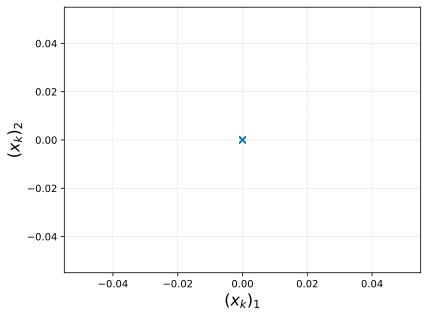

In [ ]:
#%% Robust MPC
K = 5
A = 1
B = 1

w_min = -0.5* np.ones(K+1)

w_max = 0.5* np.ones(K+1)

x_0 = np.array([0,0])

x_traj = np.zeros([n_x, T+1]) 
u_traj =  np.zeros([n_u, T])

x_traj[:, 0] = x_0

for t in range(T):
    
    x_min = cp.Variable((1, K + 1))
    x_max = cp.Variable((1, K + 1))
    u = cp.Variable((1, K))
    
    cost = 0
    constr = []
    for k in range(K):
        cost += 0.5*x_min[:, k + 1]**2 +  0.5*x_max[:, k + 1]**2 +u[:, k]**2
        constr += [x_min[:, k + 1] == A * x_min[:, k] + B * u[:, k] + w_min[k] ,
                   cp.norm(x_min[:, k], 1) <= 1,
                   x_max[:, k + 1] == A * x_max[:, k]+  B * u[:, k] + w_max[k],
                   cp.norm(x_max[:, k], 1) <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x_min[:, 0] == x_0, x_max[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = True)     
    
    if problem.status == "infeasible":
        print("###################")
        print("Problem is infeasible.")
        print("###################")
        break
        
    x_0 = A * x_0 + B * u[:,0].value
    
    u_traj[:, t] = u[:,0].value
    x_traj[:, t+1] = x_0

f1 = plt.figure()
plt.plot(x_traj[0,:], x_traj[1,:], marker = 'x')


plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xlabel("$(x_k)_1$", fontsize=16) 
plt.ylabel("$(x_k)_2$", fontsize=16) 



**Question 5:**

Can you find an initial state for which the robust MPC problem above is feasible? Why not? Why can the MPC not solve this simple problem?

**Answer 5:**

No, for a prediction horizon of $K=5$, noise of $|w_k|\leq0.5$ and state constraints of $|x_k|\leq1$ there exists no initial condition for which the open loop problem is feasible. A simple exmaple is the following, the mid point of the two limits is $x_0= 0$. If we assume the worst case disturbance acts upon the system it would be at $x_5 = \sum_{k=0}^{4} u_{k} + 5 \,w_k$, which for the positive distrubance would be $x_5 = \sum_{k=0}^{4} u_{k} + 2.5$ and for the negative it would be $x_5 = \sum_{k=0}^{4} u_{k} - 2.5$. So there is no control which could jointly keep the system within the state constraints for both possible as the control input cannot be positive and negative at the same time. The same input would have to ensure constraint satisfaction for both state trajectory realizations.

# Feedback MPC

Now using the same example from the lecture, we want to design a feedback MPC policy 
\begin{equation}
\pi_k(x_k, \mathbf{v})=v_k + L x_k
\end{equation}
wich renders the optimal control problem above feasible.

We use the same worst-case approach, but cancel some of the effect of the disturbance using the state-feedback. 

In [ ]:
#%% Feedback MPC
K = 5
A = 1
B = 1
L = -1


w_min = -0.5* np.ones(K+1)

w_max = 0.5* np.ones(K+1)

x_0 = np.array([0,0])

x_min_traj = np.zeros([n_x, T+1])
x_max_traj = np.zeros([n_x, T+1])  
u_traj =  np.zeros([n_u, T])

x_min_traj[:, 0] = x_0
x_max_traj[:, 0] = x_0



for t in range(T):
    
    x_min = cp.Variable((1, K + 1))
    x_max = cp.Variable((1, K + 1))
    u = cp.Variable((1, K))
    
    cost = 0
    constr = []
    for k in range(K):
        cost += u[:, k]**2
        constr += [x_min[:, k + 1] == (A+L)*x_min[:, k] +  u[:, k] + w_min[k] ,
                   cp.norm(x_min[:, k], 1) <= 1,
                   x_max[:, k + 1] == (A+L)*x_max[:, k]+ u[:, k] + w_max[k],
                   cp.norm(x_max[:, k], 1) <= 1]
    # sums problem objectives and concatenates constraints.
    constr += [x_min[:, 0] == x_0, x_max[:, 0] == x_0]
    problem = cp.Problem(cp.Minimize(cost), constr)
    problem.solve(verbose = False)     
    
    if problem.status == "infeasible":
        print("###################")
        print("Problem is infeasible.")
        print("###################")
        break
        
    x_0 = (A+L) * x_0 + B * u[:,0].value
    
    u_traj[:, t] = u[:,0].value
    x_min_traj[:, t+1] = x_0 + w_min[k]
    x_max_traj[:, 0] = x_0 + w_max[k]

**Question 6:**

For which values of the state-feedback gain $L$ and initial values $x_0$ is the Feedback MPC problem above feasible? Explain, why is it not feasible, for $L= 0.25$ and $x_0 = \left[\begin{smallmatrix} 0 \\ 0 \end{smallmatrix}\right]$ ? 

You can plot the outputs below.


**Asnwer 6:**

For $L=-1$ the Feedback MPC problem is feasible for any initial state $|x_0|\leq 0.5$. And also for other combinations of feedback gains and states, for example $L=-0.5 $ and $x_0=0$. The state evolution is 

\begin{equation}
x_5 = x_0 + \sum_{k=0}^4(1-L)^{4-k} (u_k+w_k) 
\end{equation}

which you can check leads to an empty set constraint set for $L=-0.25$ as described in Answer 5. 

Text(0.5, 0, '$t$')

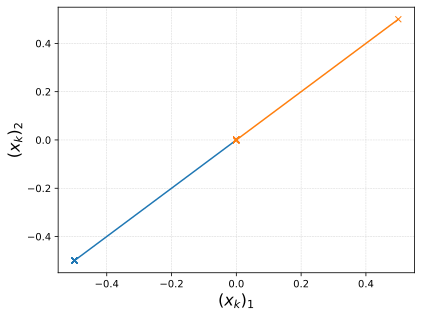

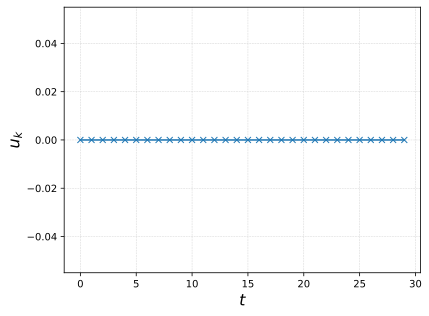

In [ ]:
# Plotting 
f1 = plt.figure()
plt.plot(x_min_traj[0,:], x_min_traj[1,:], marker = 'x')
plt.plot(x_max_traj[0,:], x_max_traj[1,:], marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xlabel("$(x_k)_1$", fontsize=16) 
plt.ylabel("$(x_k)_2$", fontsize=16) 




f2 = plt.figure()

plt.plot(u_traj[0,:].round(4), marker = 'x')

plt.plot()
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.ylabel("$u_k$", fontsize=16) 
plt.xlabel("$t$", fontsize=16) 